In [2]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from models.EdgeNet import EdgeNet, NodeNet, EdgeNODE, W1W2Net, EdgeODENet
from torch.optim import Adam

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# run only if new data is desired
ode_dim = 2
n_data = 5
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,1000)

dataset = []
for i in range(0,len(x_train)):

    # # put in bogus data
    # data_size = 2*ode_dim*n_data
    # x_train[i][:data_size] = torch.rand(data_size)
    
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=64,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    dataset.append(to_pyg_data(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [4]:
model = EdgeNet(n_data, 10, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(1000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out.flatten(), data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out.flatten(), data.y)
            # print(loss.item())
            test_loss.append(loss)

107.45105743408203
104.85413360595703
104.8768539428711
104.15863800048828
104.589111328125
104.10684204101562
103.38579559326172
102.41593170166016
102.11128997802734
101.75041198730469
100.63397216796875
100.7669906616211
100.21224212646484
100.11357879638672
99.9160385131836
100.16899871826172
100.09626770019531
101.03070068359375
100.27046203613281
100.06565856933594
98.5232925415039
98.24378204345703
99.38249969482422
98.20713806152344
97.51631927490234
97.85922241210938
97.39643859863281
97.42411041259766
96.87374114990234
96.60789489746094
96.27120971679688
96.64043426513672
96.22772216796875
97.31356811523438
95.89688110351562
97.42338562011719
97.2835693359375
96.04100799560547
96.97286224365234
95.06005859375
95.72525787353516
95.62085723876953
96.07161712646484
95.65228271484375
95.3996353149414
95.73938751220703
94.77212524414062
95.63558197021484
94.8222885131836
95.16712951660156
94.93368530273438
94.73938751220703
94.79903411865234
95.01786804199219
94.0548095703125
93.9

KeyboardInterrupt: 

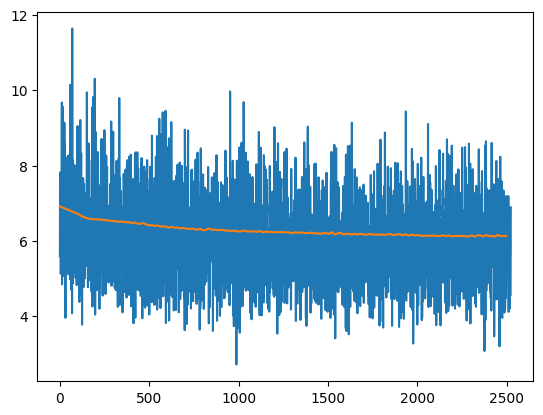

tensor([[1., 1., 1., 0.]], dtype=torch.float64)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset,batch_size=1,shuffle=True)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(batch.edge_attr.t()[0])
    print(Ainit)
    Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)